# A quick start guide

Source code: https://github.com/r9y9/nnmnkwii_gallery

In this guide, I will try to show basic usages of the library. I'd recommend that readers try this notebook locally to understatnd what the notebook does. Advanced usages can be found at the tutorials section in the documentation.

To run the notebook, in addition to nnmnkwii and its dependencies, you will need the following packages:

- pyworld: https://github.com/JeremyCCHsu/Python-Wrapper-for-World-Vocoder
- librosa: https://github.com/librosa/librosa

For ease of testing, we provide example audio/label files as well as example data sources (i.e., collection of features). Let's see how we can process them through the guide.

In [1]:
%pylab inline
rcParams["figure.figsize"] = (16,5)
from IPython.display import Audio
import librosa.display

Populating the interactive namespace from numpy and matplotlib


## Playing with audio and it's alignment file

In this section, you will learn how to prepare time-aligned linguistic/acoustic features pair, which is typically needed to train acoustic models.

### Load wav file

You can get an example file path by `example_audio_file`. Load it with `scipy.io.wavfile`. Let's see how it looks like.

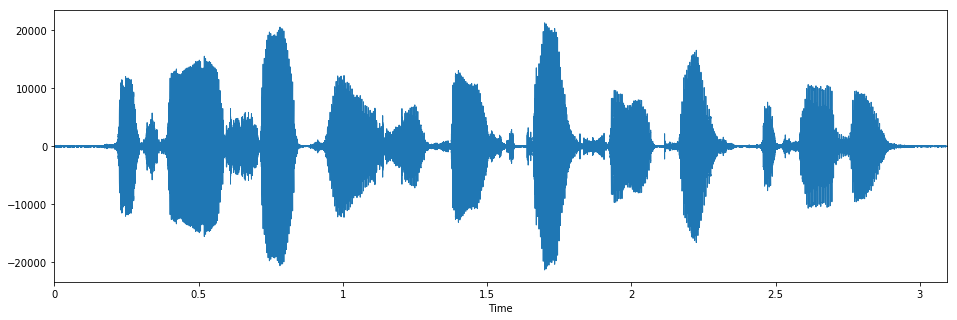

In [2]:
from nnmnkwii.util import example_audio_file
from scipy.io import wavfile

fs, x = wavfile.read(example_audio_file())
assert fs == 16000

librosa.display.waveplot(x.astype(np.float32), sr=fs)
Audio(x, rate=fs)

### Acoustic features

As same as Merlin does, we use [WORLD](https://github.com/mmorise/World), A high-quality speech analysis, manipulation and synthesis system for acoustic feature extraction purpose. In the notebook we use its python wrapper `pyworld`.

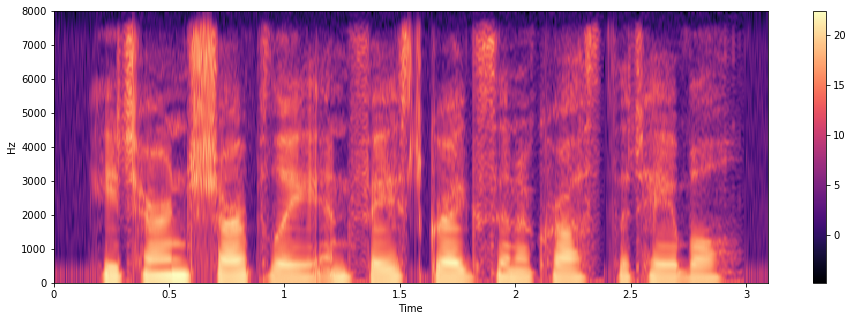

In [3]:
import pyworld

frame_period = 5 # ms
hop_length = int(0.001 * fs * frame_period)

x = x.astype(np.float64)
f0, timeaxis = pyworld.harvest(x, fs, frame_period=frame_period)
spectrogram = pyworld.cheaptrick(x, f0, timeaxis, fs)
aperiodicity = pyworld.d4c(x, f0, timeaxis, fs)

# This trims spectrum that has very small power. Just to make visualization looks good.
from nnmnkwii.preprocessing import trim_zeros_frames
spectrogram = trim_zeros_frames(spectrogram)

# Let's see spectrogram representaion
librosa.display.specshow(np.log(spectrogram).T, sr=fs, 
                         hop_length=hop_length, x_axis="time",
                         y_axis="linear", cmap="magma")
colorbar()

### Load aligment file

Along with the exmaple audio shown above, we also provide an example label file, which is  aligned with example audio. The label file was taken from Merlin's demo.

In [4]:
from nnmnkwii.util import example_label_file
from nnmnkwii.io import hts

labels = hts.load(example_label_file())
# HTS labels support indexing. It returns tuple of (start time, end time, contexts)
print(labels[0])

(0, 50000, 'x^x-sil+hh=iy@x_x/A:0_0_0/B:x-x-x@x-x&x-x#x-x$x-x!x-x;x-x|x/C:1+1+2/D:0_0/E:x+x@x+x&x+x#x+x/F:content_1/G:0_0/H:x=x@1=2|0/I:4=3/J:13+9-2[2]')


### Cut silence frames

From the full context labels, we can identify silence segments. Let's cut silence frames from acousotic features. This can be used for pre-processing.

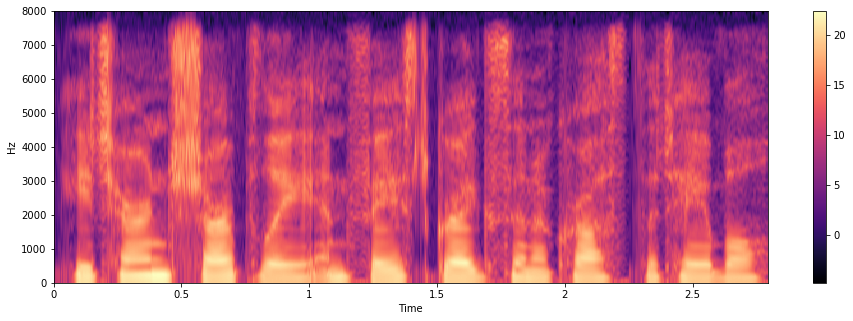

In [5]:
silence_indices = labels.silence_frame_indices()
trimmed_spectrogram = spectrogram[:labels.num_frames()]
silence_removed_spectrogram = np.delete(trimmed_spectrogram, silence_indices, axis=0)

librosa.display.specshow(np.log(silence_removed_spectrogram).T, sr=fs, 
                         hop_length=hop_length, x_axis="time",
                         y_axis="linear", cmap="magma")
colorbar()

In [6]:
silence_removed_f0 = np.delete(f0[:labels.num_frames()], silence_indices)
silence_removed_aperiodicity = np.delete(aperiodicity[:labels.num_frames()],
                                         silence_indices, axis=0)
assert len(silence_removed_f0) == len(silence_removed_aperiodicity) == len(silence_removed_spectrogram)

Let's see how it looks like in time domain. You will see that start/end silences are trimmed.

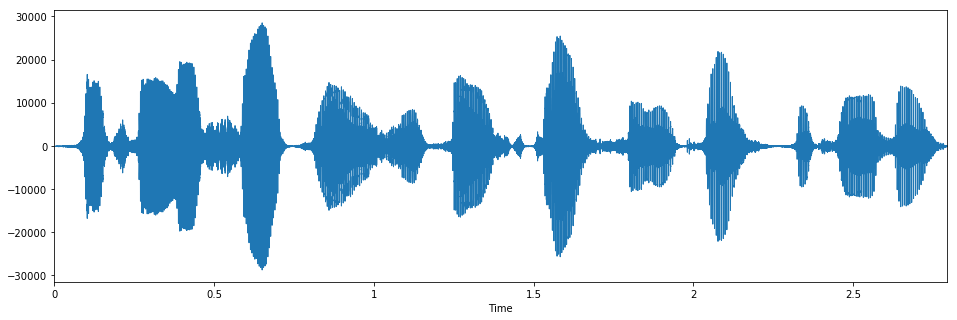

In [7]:
y = pyworld.synthesize(silence_removed_f0, silence_removed_spectrogram, silence_removed_aperiodicity,
                      fs, frame_period)
librosa.display.waveplot(y, sr=fs)
Audio(y, rate=fs)

### Linguistic features

Assuming we have linguistic contexts, in this case, full-context labels. We can convert them to its numerical form. The part of linguistic feature extraction from full-context labels were adapted from Merlin. You can use `nnmnkwii.frontend.merlin` and `nnmnkwii.util.example_question_file`  for the purpose.

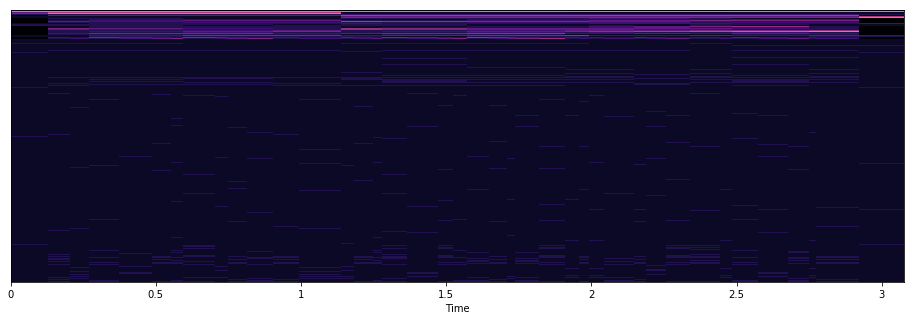

In [8]:
from nnmnkwii.frontend import merlin as fe
from nnmnkwii.util import example_question_file

binary_dict, continuous_dict = hts.load_question_set(example_question_file())
# `add_frame_features` True tells merlin frontend to extract frame-level features
linguistic_features = fe.linguistic_features(labels, binary_dict, continuous_dict,
                                            add_frame_features=True) 
# Not so good, but better than text
librosa.display.specshow(linguistic_features.T, sr=fs, 
                         hop_length=hop_length, x_axis="time", cmap="magma")

We can do same thing as we cut silences for acoustic features.

In [9]:
silence_removed_linguistic_features = np.delete(linguistic_features, silence_indices, axis=0)

In [10]:
print(silence_removed_spectrogram.shape)
print(silence_removed_linguistic_features.shape)

(559, 513)
(559, 416)


The first axis of the feature is frame (time) and second axis is the dimenton. Finally we get time-aligned frame-level linguistic/acoustic features pair. This is what we typically do to prepare data for acoustic modeing.

## Playing with datasets

Data preparetion is the hard part for many machine learning applications. In this section, you will learn how to create datasets, and how to iterate them in utterance-wise manner, as well as frame-wise manner. For details about dataset abstraction, see Dataset section in the documentation.

### Get example file sources

We use pre-computed linguistic/acoustic features from CMU ARCTIC dataset. `example_file_data_sources_for_acoustic_model` returns data sources that defines 1) where we can find example data and 2) how we load them. 

In [11]:
from nnmnkwii.util import example_file_data_sources_for_acoustic_model

X, Y = example_file_data_sources_for_acoustic_model()

### Load data

To load data, you can use our dataset implementations. In this example, we will show how the most basic `FileSourceDataset` works, which loads data on-demand while iteration or indexing.

In [12]:
from nnmnkwii.datasets import FileSourceDataset

X, Y = FileSourceDataset(X), FileSourceDataset(Y)

Note that at the moment no data is actually loaded. It just collect files to be processed according to the data source.

In [13]:
X.collected_files

array([[ '/home/ryuichi/Dropbox/sp/nnmnkwii/nnmnkwii/util/_example_data/slt_arctic_demo_data/X_acoustic/arctic_a0001.npz'],
       [ '/home/ryuichi/Dropbox/sp/nnmnkwii/nnmnkwii/util/_example_data/slt_arctic_demo_data/X_acoustic/arctic_a0002.npz'],
       [ '/home/ryuichi/Dropbox/sp/nnmnkwii/nnmnkwii/util/_example_data/slt_arctic_demo_data/X_acoustic/arctic_a0003.npz']], 
      dtype='<U110')

In [14]:
Y.collected_files

array([[ '/home/ryuichi/Dropbox/sp/nnmnkwii/nnmnkwii/util/_example_data/slt_arctic_demo_data/Y_acoustic/arctic_a0001.npz'],
       [ '/home/ryuichi/Dropbox/sp/nnmnkwii/nnmnkwii/util/_example_data/slt_arctic_demo_data/Y_acoustic/arctic_a0002.npz'],
       [ '/home/ryuichi/Dropbox/sp/nnmnkwii/nnmnkwii/util/_example_data/slt_arctic_demo_data/Y_acoustic/arctic_a0003.npz']], 
      dtype='<U110')

### Utterance-wise iteration

Since typically speech features are saved per utterance. It is nartual to support utterance-wise dataset itearation with `FileSourceDataset`. Let's try it.

In [15]:
for (x, y) in zip(X, Y):
    print("Linguistic feature shape (T, D): {}, Acoustic feature shape (T, D): {}".format(x.shape, y.shape))

Linguistic feature shape (T, D): (578, 425), Acoustic feature shape (T, D): (578, 187)
Linguistic feature shape (T, D): (675, 425), Acoustic feature shape (T, D): (675, 187)
Linguistic feature shape (T, D): (606, 425), Acoustic feature shape (T, D): (606, 187)


You can see time-aligned linguistic/acoustic feature pairs, as we did in the previous section.

#### Memory cache iteration

One of the extension of `FileSourceDataset` is that `MemoryCacheDataset`, which has cache functionality.

In [16]:
from nnmnkwii.datasets import MemoryCacheDataset

X, Y = MemoryCacheDataset(X), MemoryCacheDataset(Y)

As same in the `FileSourceDataset`, at the moment no data is loaded. It means no cached data we have so far.

In [17]:
X.cached_utterances

OrderedDict()

In [18]:
Y.cached_utterances

OrderedDict()

In [19]:
for (x, y) in zip(X, Y):
    print("Linguistic feature shape (T, D): {}, Acoustic feature shape (T, D): {}".format(x.shape, y.shape))

Linguistic feature shape (T, D): (578, 425), Acoustic feature shape (T, D): (578, 187)
Linguistic feature shape (T, D): (675, 425), Acoustic feature shape (T, D): (675, 187)
Linguistic feature shape (T, D): (606, 425), Acoustic feature shape (T, D): (606, 187)


In [20]:
len(X.cached_utterances)

3

In [21]:
len(Y.cached_utterances)

3

As you can see, after iteration, we have cached utternaces (collected features are stored as is). This is useful when we iterate dataset multiple times. 

### Frame-wise iteration

The last step of the section shows how to iterate dataset by frame-wise manner. Similar to `MemoryCacheDataset`,  we provide `MemoryCacheFramewiseDataset`. One thing I should note is that we need to give utterance lengths at dataset construction time. This is because by design, a dataset represents *fixed* sized set of features. Without utterance lengths (i.e. number of time frames for each utterance), we cannot compute size of dataset.

In [22]:
from nnmnkwii.util import example_file_data_sources_for_acoustic_model

X, Y = example_file_data_sources_for_acoustic_model()
X, Y = FileSourceDataset(X), FileSourceDataset(Y)

In [23]:
utt_lengths = [len(x) for x in X]
print(utt_lengths)

[578, 675, 606]


In [24]:
from nnmnkwii.datasets import MemoryCacheFramewiseDataset

X = MemoryCacheFramewiseDataset(X, utt_lengths)
Y = MemoryCacheFramewiseDataset(Y, utt_lengths)

In [25]:
len(X)

1859

In [26]:
len(Y)

1859

In [27]:
for (x, y) in zip(X[:3], Y[:3]):
    print("Linguistic feature dimention (D,): {}, Acoustic feature dimention (D,): {}".format(x.shape, y.shape))

Linguistic feature dimention (D,): (425,), Acoustic feature dimention (D,): (187,)
Linguistic feature dimention (D,): (425,), Acoustic feature dimention (D,): (187,)
Linguistic feature dimention (D,): (425,), Acoustic feature dimention (D,): (187,)


To the next step, you might be interested in more advanced usages. You can read tutorials for how to build DNN-based text-to-speech synthesis systems and how to build voice conversion systems.